In [47]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
# Import Heart Disease Dataset
heart_disease = pd.read_csv("../data/heart-disease.csv")

# Import Boston Housing Dataset
from sklearn.datasets import load_boston
boston = load_boston()
boston_df = pd.DataFrame(boston["data"], columns=boston["feature_names"])
boston_df["target"] = pd.Series(boston["target"])

# Step 5: Improving a model

First predictions = Baseline predictions

First model = Baseline model

### How to improve our model?

##### From a data perspective:
* Could we collect more data? (generally, the more data, the better)
* Could we improve our data? (filling in missing values or turning things into numbers)

##### From a model perspective:
* Is there a better model we could use?
* Could we improve the current model? (Can the hyperparameters be tuned to make it even better?)

### Parameters vs Hyperparameters
* **Parameters:** Model find these patterns in data
* **Hyperparameters:** Settings on a model we can adjust to (potentially) improve its ability to find patterns

In [49]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)                   # n_estimators is also a hyperparameter

In [50]:
clf.get_params()                                    # Hyperparameters

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We're going to try and adjust:
* `max_depth`
* `max_features`
* `min_samples_leaf`
* `min_samples_split`
* `n_estimators`

# Improve a model (via hyperparameter tuning)

#### Three ways to adjust hyperparameters:
1. By hand
2. Randomly with RandomizedSearchCV
3. Exhaustively with GridSearchCV

# 1. Tuning hyperparameters by hand

##### Evaluation function

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds_clf(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_preds labels on a classification model.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    return metric_dict

##### Let's make 3 sets, training, validation and test set.

In [52]:
np.random.seed(42)

# Shuffle the data
heart_disease_shuffled = heart_disease.sample(frac=1)

# Split into features (x) and label (y)
X = heart_disease_shuffled.drop("target", axis=1)
y = heart_disease_shuffled["target"]

# Split the data into train, validation & test sets
train_split = round(0.7 * len(heart_disease_shuffled))                       # 70% of data    (index of data)
valid_split = round(train_split + 0.15 * len(heart_disease_shuffled))       # 15% of data     (index of data)

X_train, y_train = X[:train_split], y[:train_split]                         # 0 --> train_split
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]   # train_split --> valid_split
X_test, y_test = X[valid_split:], y[valid_split:]                           # valid_split --> last_index

In [53]:
len(X_train), len(X_valid), len(X_test)

(212, 45, 46)

##### Random Forest Classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

# Initiate classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make baseline predictions
y_preds = clf.predict(X_valid)                               # Validation dataset

# Evaluate the classifier on validation set
baseline_metrics = evaluate_preds_clf(y_valid, y_preds)
baseline_metrics

Accuracy: 80.00%
Precision: 0.77
Recall: 0.92
F1-Score: 0.84


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'accuracy': 0.8, 'precision': 0.77, 'recall': 0.92, 'f1': 0.84}

##### Create a second classifier with different hyperparameters (n_estimators)

In [55]:
# Initiate classifier
clf_2 = RandomForestClassifier(n_estimators=100)
clf_2.fit(X_train, y_train)

# Make predictions
y_preds_2 = clf_2.predict(X_valid)

# Evaluate the 2nd classifier
clf_2_metrics = evaluate_preds_clf(y_valid, y_preds_2)
clf_2_metrics

Accuracy: 82.22%
Precision: 0.81
Recall: 0.88
F1-Score: 0.85


{'accuracy': 0.82, 'precision': 0.81, 'recall': 0.88, 'f1': 0.85}

##### Create a third classifier with different hyperparameters (n_estimators, max_depth)

In [56]:
clf_3 = RandomForestClassifier(n_estimators=100, 
                               max_depth=10)
clf_3.fit(X_train, y_train)

# Make predictions
y_preds_3 = clf_3.predict(X_valid)

# Evaluate the 2nd classifier
clf_3_metrics = evaluate_preds_clf(y_valid, y_preds_3)
clf_3_metrics

Accuracy: 86.67%
Precision: 0.85
Recall: 0.92
F1-Score: 0.88


{'accuracy': 0.87, 'precision': 0.85, 'recall': 0.92, 'f1': 0.88}

# 2. Tuning hyperparameters by RandomizedSearchCV

Scikit-Learn's RandomizedSearchCV allows us to randomly search across different hyperparameters to see which work best. It also stores details about the ones which work best!

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["sqrt", "log2"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

np.random.seed(42)

# Split into X and y
X = heart_disease_shuffled.drop("target", axis=1)
y = heart_disease_shuffled["target"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initiate RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)

# Setup RandonizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid,
                            n_iter=10,              # number of module to try
                            cv=5, 
                            verbose=2)


# Fit the RandomizedSearchCVversion of clf
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5, total=   3.1s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5, total=   2.9s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5, total=   2.5s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5, total=   2.5s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=5, total=   3.0s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=   0.3s
[CV] n_estimators=100, min_samples_split=4, min_samp

[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   0.8s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   0.7s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   0.7s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=10, total=   0.7s
[CV] n_estimators=1000, min_samples_split=4, min_samples_leaf=2, max_features=log2, max_depth=20 
[CV]  n_estimators=1000, min_samples_split=4, min_samples_leaf=2, max_features=log2, max_depth=20, total=   2.7s
[CV] n_estimators=1000, min_samples_split=4, min_s

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   50.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [58]:
rs_clf.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': None}

In [59]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_clf.predict(X_test)

# Evaluate the predictions
rs_metrics = evaluate_preds_clf(y_test, rs_y_preds)

Accuracy: 81.97%
Precision: 0.77
Recall: 0.86
F1-Score: 0.81


# 3. Tuning hyperparameters by GridSearchCV
The main difference between GridSearchCV and RandomizedSearchCV is GridSearchCV searches across a grid of hyperparamters exhaustively, where as, RandomizedSearchCV searches across a grid of hyperparameters randomly (stopping after n_iter combinations).

GridSearchCV will do brute force across a grid of hyperparameters.

In [60]:
grid

{'n_estimators': [10, 100, 200, 500, 1000, 1200],
 'max_depth': [None, 5, 10, 20, 30],
 'max_features': ['sqrt', 'log2'],
 'min_samples_split': [2, 4, 6],
 'min_samples_leaf': [1, 2, 4]}

In [61]:
(6*5*2*3*3)*(5)                                   # (no. of grid) * (cross validation) = no. of models

2700

This could take a long time depending on the power of the computer we're using, the amount of data you have and the complexity of the hyperparamters (usually higher values means a more complex model).

***Create another hyperparameter grid based on the best_params_ of rs_clf with less options:***

In [62]:
grid_2 = {'n_estimators': [100, 200, 500],
          'max_depth': [None],
          'max_features': ['sqrt', 'log2'],
          'min_samples_split': [6],
          'min_samples_leaf': [1, 2]}

In [63]:
(3*1*2*1*2)*(5)

60

In [64]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

# Split into X and y
X = heart_disease_shuffled.drop("target", axis=1)
y = heart_disease_shuffled["target"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initiate RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf,
                      param_grid=grid_2,
                      cv=5, 
                      verbose=2)

# Fit the GridSearchCVversion of clf
gs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.4s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.4s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.5s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.4s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.4s
[CV] max_depth=None, max_features=

[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.6s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500, total=   1.2s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500, total=   1.4s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500, total=   1.3s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=500, total=   1.6s
[CV] max_depth=None, max_features=

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   50.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [65]:
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 200}

In [66]:
# Make predictions with the best hyperparameters
gs_y_preds = gs_clf.predict(X_test)

# Evaluate the predictions
gs_metrics = evaluate_preds_clf(y_test, gs_y_preds)
gs_metrics

Accuracy: 78.69%
Precision: 0.74
Recall: 0.82
F1-Score: 0.78


{'accuracy': 0.79, 'precision': 0.74, 'recall': 0.82, 'f1': 0.78}

# Let's compare our different models metrics

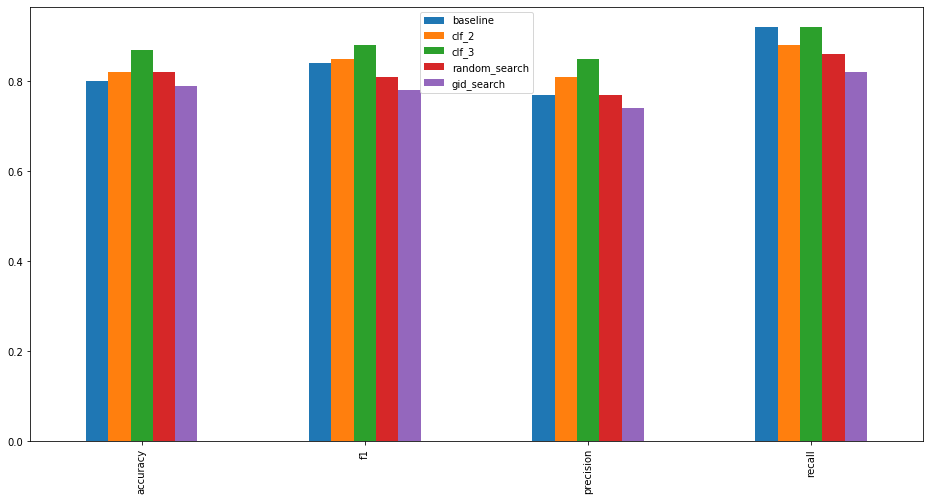

In [67]:
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "clf_2": clf_2_metrics,
                                "clf_3": clf_3_metrics,
                                "random_search": rs_metrics,
                                "gid_search": gs_metrics})
compare_metrics.plot.bar(figsize=(16,8));

# Note: Metric Comparison Improvement

We compared the metric results of 3 different models. However, there was a small error.

***In baseline Model: We evaluate our model with Validation dataset.***

but,

***In RandomizedSearchCV and GridSearchCV: We evaluate our model with Test dataset.***

As always, when comparing models, we should be careful to make sure they're compared on the same splits of data.

An example end-to-end notebook with the correct methodology has been created on Google Colab here:

https://colab.research.google.com/drive/1ISey96a5Ag6z2CvVZKVqTKNWRwZbZl0m